In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,cross_val_score,
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('Dataset/train.csv')
df_test = pd.read_csv('Dataset/test.csv')
df_train.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


In [3]:
df_train.shape,df_test.shape

((18834, 11), (8072, 9))

In [4]:
labels = df_train.iloc[:,-2:]
id_test = df_test['pet_id']
df_train = df_train.drop(['breed_category','pet_category'],axis=1)

In [5]:
df_all = pd.concat([df_train,df_test],axis=0,ignore_index=True)

In [6]:
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = total/len(df)*100
    df = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
    df = df[df['Percent']!=0]
    return df.sort_values(by='Percent',ascending=False)

In [7]:
missing_percentage(df_all)

,Total,Percent
condition,2096,7.790084


In [8]:
df_all['issue_date'] = df_all['issue_date'].apply(lambda x:x.split(' ')[0])

df_all['isd_date'] = df_all['issue_date'].apply(lambda x:x.split('-')[2])
df_all['isd_month'] = df_all['issue_date'].apply(lambda x:x.split('-')[1])
df_all['isd_year'] = df_all['issue_date'].apply(lambda x:x.split('-')[0])

df_all.drop('issue_date',axis=1,inplace=True)

In [9]:
df_all['list_date'] = df_all['listing_date'].apply(lambda x:x.split(' ')[0])
df_all['list_time'] = df_all['listing_date'].apply(lambda x:x.split(' ')[1])

df_all.drop('listing_date',axis=1,inplace=True)

In [10]:
df_all['lst_date'] = df_all['list_date'].apply(lambda x:x.split('-')[2])
df_all['lst_month'] = df_all['list_date'].apply(lambda x:x.split('-')[1])
df_all['lst_year'] = df_all['list_date'].apply(lambda x:x.split('-')[0])
df_all = df_all.drop('list_date',axis=1)

list_time = df_all['list_time']
df_all = df_all.drop(['list_time','pet_id'],axis=1)

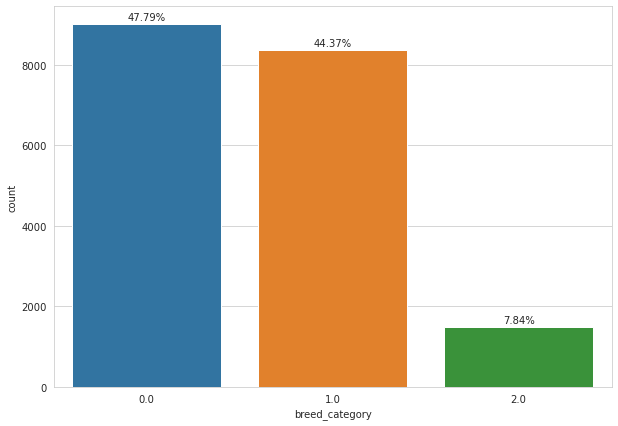

In [11]:
sns.set_style('whitegrid')

order1 = labels['breed_category'].value_counts()
order2 = order1.index
plt.figure(figsize=(10,7))
sns.countplot(labels['breed_category'],order=order2)

for i in range(order1.shape[0]):
    count = order1[i]
    strg = '{:0.2f}%'.format(100*count/labels.shape[0])
    plt.text(i,count+100,strg,ha='center')

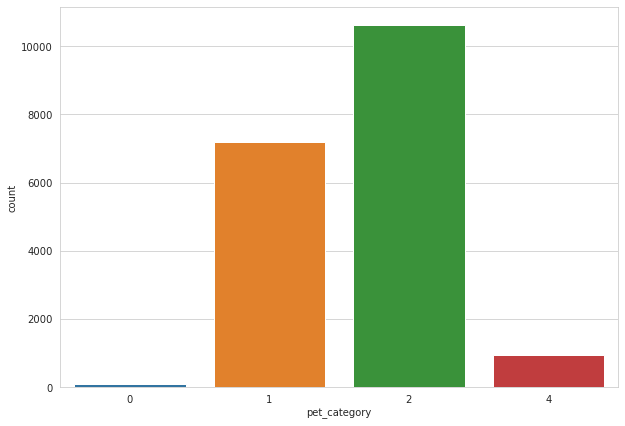

In [12]:
plt.figure(figsize=(10,7))
sns.countplot(labels['pet_category'])

In [13]:
#df_all['color_type'] = df_all['color_type'].apply(lambda x:x[0])#

df_all['isd_date'] = df_all['isd_date'].astype('int64')
df_all['lst_date'] = df_all['lst_date'].astype('int64')

In [14]:
df_all.head()

,condition,color_type,length(m),height(cm),X1,X2,isd_date,isd_month,isd_year,lst_date,lst_month,lst_year
0,2.0,Brown Tabby,0.80,7.78,13,9,10,07,2016,21,09,2016
1,1.0,White,0.72,14.19,13,9,21,11,2013,27,12,2018
2,NaN,Brown,0.15,40.90,15,4,28,09,2014,19,10,2016
3,1.0,White,0.62,17.82,0,1,31,12,2016,25,01,2019
4,2.0,Black,0.50,11.06,18,4,28,09,2017,19,11,2017


In [15]:
def value_counts(df):
    a = {}
    for column in df.columns:
        a[column] = len(df[column].value_counts())
    return a

In [16]:
def Categorical(df):
    categories = []
    for column in df.columns:
        if df[column].dtype =='object' or len(df[column].value_counts()) < 32:
            categories.append(column)
    return categories

In [17]:
df_all['isd_month'] = df_all['isd_month'].astype('int')
df_all['lst_month'] = df_all['lst_month'].astype('int')

In [18]:
def month_to_date(n):
    total = 0
    memo = {1:31,2:28,3:31,4:30}
    memo[6] = memo[9] = memo[11] = memo[4]
    memo[5] = memo[7] = memo[8] = memo[10] = memo[12] = memo[1]
    
    for i in range(1,n+1):
        total = total+memo[i]
    return total

In [19]:
df_all['monthindate'] = df_all['isd_month'].apply(month_to_date)
df_all['isd D-M'] = df_all['monthindate']+df_all['isd_date']
df_all.drop('monthindate',axis=1,inplace=True)


df_all['monthindate'] = df_all['lst_month'].apply(month_to_date)
df_all['lst D-M'] = df_all['monthindate']+df_all['lst_date']
df_all.drop('monthindate',axis=1,inplace=True)

In [20]:
df_all['length(cm)'] = df_all['length(m)'].apply(lambda x:x*100)
df_all['area'] = df_all['length(cm)']*df_all['height(cm)']

df_all['X1+X2'] = df_all['X1']+df_all['X2']

In [21]:
df_all.head()

,condition,color_type,length(m),height(cm),X1,X2,isd_date,isd_month,isd_year,lst_date,lst_month,lst_year,isd D-M,lst D-M,length(cm),area,X1+X2
0,2.0,Brown Tabby,0.80,7.78,13,9,10,7,2016,21,9,2016,222,294,80.0,622.40,22
1,1.0,White,0.72,14.19,13,9,21,11,2013,27,12,2018,355,392,72.0,1021.68,22
2,NaN,Brown,0.15,40.90,15,4,28,9,2014,19,10,2016,301,323,15.0,613.50,19
3,1.0,White,0.62,17.82,0,1,31,12,2016,25,1,2019,396,56,62.0,1104.84,1
4,2.0,Black,0.50,11.06,18,4,28,9,2017,19,11,2017,301,353,50.0,553.00,22


In [22]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26906 entries, 0 to 26905
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   condition   24810 non-null  float64
 1   color_type  26906 non-null  object 
 2   length(m)   26906 non-null  float64
 3   height(cm)  26906 non-null  float64
 4   X1          26906 non-null  int64  
 5   X2          26906 non-null  int64  
 6   isd_date    26906 non-null  int64  
 7   isd_month   26906 non-null  int64  
 8   isd_year    26906 non-null  object 
 9   lst_date    26906 non-null  int64  
 10  lst_month   26906 non-null  int64  
 11  lst_year    26906 non-null  object 
 12  isd D-M     26906 non-null  int64  
 13  lst D-M     26906 non-null  int64  
 14  length(cm)  26906 non-null  float64
 15  area        26906 non-null  float64
 16  X1+X2       26906 non-null  int64  
dtypes: float64(5), int64(9), object(3)
memory usage: 3.5+ MB


In [23]:
value_counts(df_all)

{'condition': 3,
 'color_type': 56,
 'length(m)': 101,
 'height(cm)': 4489,
 'X1': 20,
 'X2': 10,
 'isd_date': 31,
 'isd_month': 12,
 'isd_year': 27,
 'lst_date': 31,
 'lst_month': 12,
 'lst_year': 5,
 'isd D-M': 356,
 'lst D-M': 354,
 'length(cm)': 101,
 'area': 24387,
 'X1+X2': 21}

In [24]:
cato = Categorical(df_all)
cato.remove('condition')
    
df_all[cato] = df_all[cato].astype('object')
onehot = pd.get_dummies(df_all[cato],drop_first = True)

df_all = df_all.drop(cato,axis=1)
df_all = pd.concat([df_all,onehot],axis=1)

In [25]:
df_all.head()

,condition,length(m),height(cm),isd D-M,lst D-M,length(cm),area,color_type_Apricot,color_type_Black,color_type_Black Brindle,...,X1+X2_11,X1+X2_12,X1+X2_13,X1+X2_14,X1+X2_15,X1+X2_19,X1+X2_22,X1+X2_23,X1+X2_25,X1+X2_26
0,2.0,0.80,7.78,222,294,80.0,622.40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1.0,0.72,14.19,355,392,72.0,1021.68,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,NaN,0.15,40.90,301,323,15.0,613.50,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.0,0.62,17.82,396,56,62.0,1104.84,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,0.50,11.06,301,353,50.0,553.00,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [26]:
labels.head()

,breed_category,pet_category
0,0.0,1
1,0.0,2
2,2.0,4
3,0.0,2
4,0.0,1


In [27]:
train = df_all.iloc[0:len(df_train),:]
test = df_all.iloc[len(df_train):,:]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state=0)

In [29]:
def total_score(f1,f2):
    score = 100*(f1+f2)/2
    return score

In [ ]:
clf1 = XGBClassifier()
clf1.fit(X_train,y_train.iloc[:,0])

y_pred1 = clf1.predict(X_test)
f1 = metrics.f1_score(y_test.iloc[:,0],y_pred1,average='weighted')


clf2 = XGBClassifier()
clf2.fit(np.concatenate([X_train,y_train.iloc[:,0].values.reshape(-1,1)],axis=1),y_train.iloc[:,1])

y_pred2 = clf2.predict(np.concatenate([X_test,y_pred1.reshape(-1,1)],axis=1))
f2 = metrics.f1_score(y_test.iloc[:,1],y_pred2,average='weighted')

In [31]:
print(f1,f2)
print(total_score(f1,f2))

0.9096969577357142 0.9011729851167555
90.54349714262348


In [38]:
lgb1 = LGBMClassifier()
lgb1.fit(X_train,y_train.iloc[:,0])

y_pred_lgb1 = lgb1.predict(X_test)
lgb_f1 = metrics.f1_score(y_test.iloc[:,0],y_pred_lgb1,average='weighted')


lgb2 = LGBMClassifier()
lgb2.fit(np.concatenate([X_train,y_train.iloc[:,0].values.reshape(-1,1)],axis=1),y_train.iloc[:,1])

y_pred_lgb2 = lgb2.predict(np.concatenate([X_test,y_pred_lgb1.reshape(-1,1)],axis=1))
lgb_f2 = metrics.f1_score(y_test.iloc[:,1],y_pred_lgb2,average='weighted')

In [39]:
print(lgb_f1,lgb_f2)
print(total_score(lgb_f1,lgb_f2))

0.9120859581959969 0.8968693441323047
90.44776511641508


In [46]:
cb1 = CatBoostClassifier()
cb1.fit(X_train,y_train.iloc[:,0])

y_pred_cb1 = cb1.predict(X_test)
cb_f1 = metrics.f1_score(y_test.iloc[:,0],y_pred_cb1,average='weighted')


cb2 = CatBoostClassifier()
cb2.fit(np.concatenate([X_train,y_train.iloc[:,0].values.reshape(-1,1)],axis=1),y_train.iloc[:,1])

y_pred_cb2 = cb2.predict(np.concatenate([X_test,y_pred_cb1.reshape(-1,1)],axis=1))
cb_f2 = metrics.f1_score(y_test.iloc[:,1],y_pred_cb2,average='weighted')

Learning rate set to 0.090866
0:	learn: 0.9566989	total: 10.6ms	remaining: 10.6s
1:	learn: 0.8461707	total: 17.7ms	remaining: 8.83s
2:	learn: 0.7580629	total: 28.2ms	remaining: 9.36s
3:	learn: 0.6854856	total: 38ms	remaining: 9.47s
4:	learn: 0.6239589	total: 45.3ms	remaining: 9.01s
5:	learn: 0.5719596	total: 55.4ms	remaining: 9.17s
6:	learn: 0.5273901	total: 65.2ms	remaining: 9.25s
7:	learn: 0.4885472	total: 75.1ms	remaining: 9.31s
8:	learn: 0.4544493	total: 84.3ms	remaining: 9.28s
9:	learn: 0.4243804	total: 93.5ms	remaining: 9.25s
10:	learn: 0.3978799	total: 103ms	remaining: 9.27s
11:	learn: 0.3745459	total: 113ms	remaining: 9.3s
12:	learn: 0.3536146	total: 123ms	remaining: 9.31s
13:	learn: 0.3349144	total: 132ms	remaining: 9.29s
14:	learn: 0.3173503	total: 142ms	remaining: 9.29s
15:	learn: 0.3018677	total: 151ms	remaining: 9.27s
16:	learn: 0.2882802	total: 158ms	remaining: 9.11s
17:	learn: 0.2755511	total: 167ms	remaining: 9.11s
18:	learn: 0.2645359	total: 177ms	remaining: 9.13s
19:	

168:	learn: 0.1417846	total: 1.63s	remaining: 8.02s
169:	learn: 0.1416904	total: 1.64s	remaining: 8s
170:	learn: 0.1415994	total: 1.65s	remaining: 7.99s
171:	learn: 0.1415040	total: 1.66s	remaining: 7.98s
172:	learn: 0.1414192	total: 1.67s	remaining: 7.97s
173:	learn: 0.1413479	total: 1.68s	remaining: 7.95s
174:	learn: 0.1412972	total: 1.68s	remaining: 7.94s
175:	learn: 0.1412126	total: 1.69s	remaining: 7.92s
176:	learn: 0.1410041	total: 1.7s	remaining: 7.91s
177:	learn: 0.1409033	total: 1.71s	remaining: 7.9s
178:	learn: 0.1408708	total: 1.72s	remaining: 7.89s
179:	learn: 0.1408452	total: 1.73s	remaining: 7.87s
180:	learn: 0.1407399	total: 1.74s	remaining: 7.87s
181:	learn: 0.1406862	total: 1.75s	remaining: 7.85s
182:	learn: 0.1405820	total: 1.76s	remaining: 7.84s
183:	learn: 0.1404105	total: 1.77s	remaining: 7.83s
184:	learn: 0.1403716	total: 1.78s	remaining: 7.85s
185:	learn: 0.1402796	total: 1.79s	remaining: 7.85s
186:	learn: 0.1401668	total: 1.8s	remaining: 7.84s
187:	learn: 0.1400

339:	learn: 0.1285424	total: 3.26s	remaining: 6.33s
340:	learn: 0.1285027	total: 3.27s	remaining: 6.32s
341:	learn: 0.1283940	total: 3.28s	remaining: 6.31s
342:	learn: 0.1283500	total: 3.29s	remaining: 6.3s
343:	learn: 0.1282917	total: 3.3s	remaining: 6.29s
344:	learn: 0.1282572	total: 3.31s	remaining: 6.28s
345:	learn: 0.1281717	total: 3.32s	remaining: 6.27s
346:	learn: 0.1280958	total: 3.33s	remaining: 6.26s
347:	learn: 0.1280110	total: 3.34s	remaining: 6.25s
348:	learn: 0.1278543	total: 3.35s	remaining: 6.25s
349:	learn: 0.1277997	total: 3.36s	remaining: 6.24s
350:	learn: 0.1277374	total: 3.37s	remaining: 6.23s
351:	learn: 0.1277099	total: 3.38s	remaining: 6.22s
352:	learn: 0.1276894	total: 3.39s	remaining: 6.21s
353:	learn: 0.1275813	total: 3.4s	remaining: 6.2s
354:	learn: 0.1275262	total: 3.4s	remaining: 6.19s
355:	learn: 0.1274761	total: 3.42s	remaining: 6.18s
356:	learn: 0.1273545	total: 3.42s	remaining: 6.17s
357:	learn: 0.1273100	total: 3.43s	remaining: 6.16s
358:	learn: 0.127

512:	learn: 0.1178137	total: 5.11s	remaining: 4.85s
513:	learn: 0.1177530	total: 5.12s	remaining: 4.84s
514:	learn: 0.1177036	total: 5.13s	remaining: 4.83s
515:	learn: 0.1176476	total: 5.15s	remaining: 4.83s
516:	learn: 0.1175864	total: 5.16s	remaining: 4.82s
517:	learn: 0.1175546	total: 5.17s	remaining: 4.81s
518:	learn: 0.1174701	total: 5.18s	remaining: 4.81s
519:	learn: 0.1173759	total: 5.2s	remaining: 4.8s
520:	learn: 0.1173297	total: 5.21s	remaining: 4.79s
521:	learn: 0.1172466	total: 5.22s	remaining: 4.78s
522:	learn: 0.1171853	total: 5.24s	remaining: 4.78s
523:	learn: 0.1171375	total: 5.25s	remaining: 4.77s
524:	learn: 0.1170950	total: 5.26s	remaining: 4.76s
525:	learn: 0.1170268	total: 5.27s	remaining: 4.75s
526:	learn: 0.1169958	total: 5.28s	remaining: 4.74s
527:	learn: 0.1169331	total: 5.29s	remaining: 4.73s
528:	learn: 0.1169021	total: 5.3s	remaining: 4.72s
529:	learn: 0.1168468	total: 5.31s	remaining: 4.71s
530:	learn: 0.1167515	total: 5.32s	remaining: 4.7s
531:	learn: 0.11

677:	learn: 0.1095004	total: 6.73s	remaining: 3.2s
678:	learn: 0.1094642	total: 6.74s	remaining: 3.19s
679:	learn: 0.1094155	total: 6.75s	remaining: 3.18s
680:	learn: 0.1092838	total: 6.76s	remaining: 3.17s
681:	learn: 0.1092638	total: 6.78s	remaining: 3.16s
682:	learn: 0.1091683	total: 6.79s	remaining: 3.15s
683:	learn: 0.1091214	total: 6.8s	remaining: 3.14s
684:	learn: 0.1090613	total: 6.8s	remaining: 3.13s
685:	learn: 0.1090388	total: 6.82s	remaining: 3.12s
686:	learn: 0.1089869	total: 6.84s	remaining: 3.12s
687:	learn: 0.1089539	total: 6.86s	remaining: 3.11s
688:	learn: 0.1088962	total: 6.88s	remaining: 3.1s
689:	learn: 0.1088578	total: 6.89s	remaining: 3.1s
690:	learn: 0.1088161	total: 6.9s	remaining: 3.09s
691:	learn: 0.1087754	total: 6.92s	remaining: 3.08s
692:	learn: 0.1087247	total: 6.93s	remaining: 3.07s
693:	learn: 0.1086233	total: 6.95s	remaining: 3.06s
694:	learn: 0.1085778	total: 6.97s	remaining: 3.06s
695:	learn: 0.1085544	total: 6.98s	remaining: 3.05s
696:	learn: 0.1085

855:	learn: 0.1011634	total: 8.55s	remaining: 1.44s
856:	learn: 0.1011363	total: 8.56s	remaining: 1.43s
857:	learn: 0.1011170	total: 8.56s	remaining: 1.42s
858:	learn: 0.1010873	total: 8.57s	remaining: 1.41s
859:	learn: 0.1010559	total: 8.58s	remaining: 1.4s
860:	learn: 0.1010173	total: 8.59s	remaining: 1.39s
861:	learn: 0.1009638	total: 8.6s	remaining: 1.38s
862:	learn: 0.1009249	total: 8.61s	remaining: 1.37s
863:	learn: 0.1008630	total: 8.62s	remaining: 1.36s
864:	learn: 0.1008137	total: 8.63s	remaining: 1.35s
865:	learn: 0.1007562	total: 8.65s	remaining: 1.34s
866:	learn: 0.1007196	total: 8.65s	remaining: 1.33s
867:	learn: 0.1006944	total: 8.66s	remaining: 1.32s
868:	learn: 0.1006393	total: 8.67s	remaining: 1.31s
869:	learn: 0.1006112	total: 8.68s	remaining: 1.3s
870:	learn: 0.1005991	total: 8.69s	remaining: 1.29s
871:	learn: 0.1005654	total: 8.7s	remaining: 1.28s
872:	learn: 0.1005226	total: 8.71s	remaining: 1.27s
873:	learn: 0.1004923	total: 8.72s	remaining: 1.26s
874:	learn: 0.10

23:	learn: 0.4752259	total: 262ms	remaining: 10.7s
24:	learn: 0.4676758	total: 273ms	remaining: 10.6s
25:	learn: 0.4614974	total: 284ms	remaining: 10.6s
26:	learn: 0.4540053	total: 294ms	remaining: 10.6s
27:	learn: 0.4492735	total: 305ms	remaining: 10.6s
28:	learn: 0.4443306	total: 316ms	remaining: 10.6s
29:	learn: 0.4385282	total: 327ms	remaining: 10.6s
30:	learn: 0.4333670	total: 337ms	remaining: 10.5s
31:	learn: 0.4294223	total: 347ms	remaining: 10.5s
32:	learn: 0.4237837	total: 357ms	remaining: 10.5s
33:	learn: 0.4203295	total: 367ms	remaining: 10.4s
34:	learn: 0.4166601	total: 377ms	remaining: 10.4s
35:	learn: 0.4126444	total: 387ms	remaining: 10.4s
36:	learn: 0.4102673	total: 397ms	remaining: 10.3s
37:	learn: 0.4063798	total: 407ms	remaining: 10.3s
38:	learn: 0.4031253	total: 417ms	remaining: 10.3s
39:	learn: 0.4005815	total: 427ms	remaining: 10.2s
40:	learn: 0.3980338	total: 438ms	remaining: 10.2s
41:	learn: 0.3953574	total: 449ms	remaining: 10.3s
42:	learn: 0.3929597	total: 459

201:	learn: 0.2802707	total: 2.1s	remaining: 8.29s
202:	learn: 0.2799814	total: 2.11s	remaining: 8.28s
203:	learn: 0.2797555	total: 2.12s	remaining: 8.27s
204:	learn: 0.2791040	total: 2.13s	remaining: 8.26s
205:	learn: 0.2787212	total: 2.14s	remaining: 8.25s
206:	learn: 0.2785055	total: 2.15s	remaining: 8.24s
207:	learn: 0.2783362	total: 2.16s	remaining: 8.23s
208:	learn: 0.2778371	total: 2.17s	remaining: 8.21s
209:	learn: 0.2776178	total: 2.18s	remaining: 8.2s
210:	learn: 0.2774109	total: 2.19s	remaining: 8.19s
211:	learn: 0.2770272	total: 2.2s	remaining: 8.18s
212:	learn: 0.2766858	total: 2.21s	remaining: 8.16s
213:	learn: 0.2762829	total: 2.22s	remaining: 8.16s
214:	learn: 0.2760957	total: 2.23s	remaining: 8.14s
215:	learn: 0.2758158	total: 2.24s	remaining: 8.13s
216:	learn: 0.2756078	total: 2.25s	remaining: 8.12s
217:	learn: 0.2754610	total: 2.26s	remaining: 8.11s
218:	learn: 0.2751977	total: 2.27s	remaining: 8.1s
219:	learn: 0.2750635	total: 2.28s	remaining: 8.09s
220:	learn: 0.27

374:	learn: 0.2455384	total: 3.92s	remaining: 6.54s
375:	learn: 0.2450170	total: 3.94s	remaining: 6.53s
376:	learn: 0.2448586	total: 3.95s	remaining: 6.52s
377:	learn: 0.2444393	total: 3.96s	remaining: 6.51s
378:	learn: 0.2443668	total: 3.97s	remaining: 6.5s
379:	learn: 0.2441680	total: 3.98s	remaining: 6.49s
380:	learn: 0.2440782	total: 3.99s	remaining: 6.48s
381:	learn: 0.2439707	total: 4s	remaining: 6.47s
382:	learn: 0.2438720	total: 4.01s	remaining: 6.46s
383:	learn: 0.2436419	total: 4.02s	remaining: 6.45s
384:	learn: 0.2434721	total: 4.03s	remaining: 6.44s
385:	learn: 0.2431488	total: 4.04s	remaining: 6.43s
386:	learn: 0.2430095	total: 4.05s	remaining: 6.42s
387:	learn: 0.2429068	total: 4.06s	remaining: 6.41s
388:	learn: 0.2427742	total: 4.07s	remaining: 6.4s
389:	learn: 0.2424873	total: 4.08s	remaining: 6.39s
390:	learn: 0.2424063	total: 4.09s	remaining: 6.38s
391:	learn: 0.2423300	total: 4.1s	remaining: 6.37s
392:	learn: 0.2422657	total: 4.11s	remaining: 6.35s
393:	learn: 0.2418

550:	learn: 0.2209187	total: 5.77s	remaining: 4.7s
551:	learn: 0.2208052	total: 5.78s	remaining: 4.69s
552:	learn: 0.2206818	total: 5.79s	remaining: 4.68s
553:	learn: 0.2205995	total: 5.8s	remaining: 4.67s
554:	learn: 0.2204534	total: 5.81s	remaining: 4.66s
555:	learn: 0.2203528	total: 5.82s	remaining: 4.65s
556:	learn: 0.2202919	total: 5.83s	remaining: 4.64s
557:	learn: 0.2200764	total: 5.84s	remaining: 4.63s
558:	learn: 0.2199469	total: 5.85s	remaining: 4.62s
559:	learn: 0.2197554	total: 5.86s	remaining: 4.61s
560:	learn: 0.2196606	total: 5.87s	remaining: 4.6s
561:	learn: 0.2194862	total: 5.88s	remaining: 4.59s
562:	learn: 0.2194547	total: 5.89s	remaining: 4.58s
563:	learn: 0.2194038	total: 5.91s	remaining: 4.57s
564:	learn: 0.2191907	total: 5.92s	remaining: 4.55s
565:	learn: 0.2190914	total: 5.93s	remaining: 4.54s
566:	learn: 0.2188309	total: 5.94s	remaining: 4.53s
567:	learn: 0.2184704	total: 5.95s	remaining: 4.52s
568:	learn: 0.2183777	total: 5.96s	remaining: 4.51s
569:	learn: 0.2

720:	learn: 0.2026376	total: 7.61s	remaining: 2.94s
721:	learn: 0.2025469	total: 7.62s	remaining: 2.93s
722:	learn: 0.2024736	total: 7.64s	remaining: 2.93s
723:	learn: 0.2023618	total: 7.65s	remaining: 2.92s
724:	learn: 0.2021941	total: 7.67s	remaining: 2.91s
725:	learn: 0.2021146	total: 7.69s	remaining: 2.9s
726:	learn: 0.2020370	total: 7.7s	remaining: 2.89s
727:	learn: 0.2020209	total: 7.71s	remaining: 2.88s
728:	learn: 0.2019756	total: 7.72s	remaining: 2.87s
729:	learn: 0.2018773	total: 7.73s	remaining: 2.86s
730:	learn: 0.2017204	total: 7.74s	remaining: 2.85s
731:	learn: 0.2016491	total: 7.75s	remaining: 2.84s
732:	learn: 0.2015824	total: 7.76s	remaining: 2.83s
733:	learn: 0.2015424	total: 7.77s	remaining: 2.82s
734:	learn: 0.2013447	total: 7.78s	remaining: 2.81s
735:	learn: 0.2012508	total: 7.79s	remaining: 2.79s
736:	learn: 0.2010569	total: 7.8s	remaining: 2.78s
737:	learn: 0.2009927	total: 7.81s	remaining: 2.77s
738:	learn: 0.2008586	total: 7.83s	remaining: 2.76s
739:	learn: 0.2

887:	learn: 0.1867805	total: 9.45s	remaining: 1.19s
888:	learn: 0.1866641	total: 9.46s	remaining: 1.18s
889:	learn: 0.1865837	total: 9.47s	remaining: 1.17s
890:	learn: 0.1865653	total: 9.48s	remaining: 1.16s
891:	learn: 0.1865242	total: 9.49s	remaining: 1.15s
892:	learn: 0.1864356	total: 9.5s	remaining: 1.14s
893:	learn: 0.1863968	total: 9.51s	remaining: 1.13s
894:	learn: 0.1862879	total: 9.52s	remaining: 1.12s
895:	learn: 0.1862117	total: 9.53s	remaining: 1.1s
896:	learn: 0.1861553	total: 9.54s	remaining: 1.09s
897:	learn: 0.1860398	total: 9.55s	remaining: 1.08s
898:	learn: 0.1859988	total: 9.56s	remaining: 1.07s
899:	learn: 0.1859102	total: 9.57s	remaining: 1.06s
900:	learn: 0.1858340	total: 9.58s	remaining: 1.05s
901:	learn: 0.1857724	total: 9.59s	remaining: 1.04s
902:	learn: 0.1857166	total: 9.6s	remaining: 1.03s
903:	learn: 0.1856048	total: 9.61s	remaining: 1.02s
904:	learn: 0.1855597	total: 9.62s	remaining: 1.01s
905:	learn: 0.1855074	total: 9.63s	remaining: 999ms
906:	learn: 0.1

In [47]:
print(cb_f1,cb_f2)
print(total_score(cb_f1,cb_f2))

0.9091685570910408 0.8990113744041848
90.40899657476128


In [51]:
vot_clf = VotingClassifier(estimators=[('xgboost',clf1),
                                       #('rf',rf_clf1),
                                       #('bg',bg_clf1),
                                       ('lgb',lgb1),
                                       ('cb',cb1)], voting='soft')
vot_clf.fit(X_train,y_train.iloc[:,0])

y_pred_vot1 = vot_clf.predict(X_test)
vot_f1 = metrics.f1_score(y_test.iloc[:,0],y_pred_vot1,average='weighted')


vot_clf2 = VotingClassifier(estimators=[('xgboost',clf2),
                                        #('rf',rf_clf2),
                                        #('bg',bg_clf2),
                                        ('lgb',lgb2),
                                        ('cb',cb1)], voting='soft')
vot_clf2.fit(np.concatenate([X_train,y_train.iloc[:,0].values.reshape(-1,1)],axis=1),y_train.iloc[:,1])

y_pred_vot2 = vot_clf2.predict(np.concatenate([X_test,y_pred_vot1.reshape(-1,1)],axis=1))
vot_f2 = metrics.f1_score(y_test.iloc[:,1],y_pred_vot2,average='weighted')

Learning rate set to 0.090866
0:	learn: 0.9566989	total: 17.7ms	remaining: 17.7s
1:	learn: 0.8461707	total: 31.5ms	remaining: 15.7s
2:	learn: 0.7580629	total: 51.3ms	remaining: 17.1s
3:	learn: 0.6854856	total: 70.1ms	remaining: 17.5s
4:	learn: 0.6239589	total: 83.6ms	remaining: 16.6s
5:	learn: 0.5719596	total: 97.6ms	remaining: 16.2s
6:	learn: 0.5273901	total: 107ms	remaining: 15.2s
7:	learn: 0.4885472	total: 117ms	remaining: 14.5s
8:	learn: 0.4544493	total: 127ms	remaining: 13.9s
9:	learn: 0.4243804	total: 136ms	remaining: 13.5s
10:	learn: 0.3978799	total: 146ms	remaining: 13.1s
11:	learn: 0.3745459	total: 155ms	remaining: 12.8s
12:	learn: 0.3536146	total: 165ms	remaining: 12.5s
13:	learn: 0.3349144	total: 175ms	remaining: 12.3s
14:	learn: 0.3173503	total: 184ms	remaining: 12.1s
15:	learn: 0.3018677	total: 196ms	remaining: 12.1s
16:	learn: 0.2882802	total: 204ms	remaining: 11.8s
17:	learn: 0.2755511	total: 213ms	remaining: 11.6s
18:	learn: 0.2645359	total: 223ms	remaining: 11.5s
19:	l

170:	learn: 0.1415994	total: 1.64s	remaining: 7.93s
171:	learn: 0.1415040	total: 1.65s	remaining: 7.92s
172:	learn: 0.1414192	total: 1.65s	remaining: 7.91s
173:	learn: 0.1413479	total: 1.66s	remaining: 7.9s
174:	learn: 0.1412972	total: 1.67s	remaining: 7.88s
175:	learn: 0.1412126	total: 1.68s	remaining: 7.87s
176:	learn: 0.1410041	total: 1.69s	remaining: 7.86s
177:	learn: 0.1409033	total: 1.7s	remaining: 7.85s
178:	learn: 0.1408708	total: 1.71s	remaining: 7.84s
179:	learn: 0.1408452	total: 1.72s	remaining: 7.82s
180:	learn: 0.1407399	total: 1.73s	remaining: 7.81s
181:	learn: 0.1406862	total: 1.74s	remaining: 7.8s
182:	learn: 0.1405820	total: 1.74s	remaining: 7.79s
183:	learn: 0.1404105	total: 1.75s	remaining: 7.78s
184:	learn: 0.1403716	total: 1.76s	remaining: 7.77s
185:	learn: 0.1402796	total: 1.77s	remaining: 7.76s
186:	learn: 0.1401668	total: 1.78s	remaining: 7.75s
187:	learn: 0.1400268	total: 1.79s	remaining: 7.74s
188:	learn: 0.1398263	total: 1.8s	remaining: 7.72s
189:	learn: 0.13

337:	learn: 0.1286596	total: 3.26s	remaining: 6.39s
338:	learn: 0.1286114	total: 3.27s	remaining: 6.38s
339:	learn: 0.1285424	total: 3.28s	remaining: 6.37s
340:	learn: 0.1285027	total: 3.29s	remaining: 6.36s
341:	learn: 0.1283940	total: 3.3s	remaining: 6.35s
342:	learn: 0.1283500	total: 3.31s	remaining: 6.34s
343:	learn: 0.1282917	total: 3.32s	remaining: 6.33s
344:	learn: 0.1282572	total: 3.33s	remaining: 6.32s
345:	learn: 0.1281717	total: 3.34s	remaining: 6.31s
346:	learn: 0.1280958	total: 3.35s	remaining: 6.3s
347:	learn: 0.1280110	total: 3.36s	remaining: 6.29s
348:	learn: 0.1278543	total: 3.37s	remaining: 6.28s
349:	learn: 0.1277997	total: 3.38s	remaining: 6.27s
350:	learn: 0.1277374	total: 3.39s	remaining: 6.26s
351:	learn: 0.1277099	total: 3.4s	remaining: 6.25s
352:	learn: 0.1276894	total: 3.4s	remaining: 6.24s
353:	learn: 0.1275813	total: 3.41s	remaining: 6.23s
354:	learn: 0.1275262	total: 3.42s	remaining: 6.22s
355:	learn: 0.1274761	total: 3.43s	remaining: 6.21s
356:	learn: 0.12

506:	learn: 0.1181143	total: 4.89s	remaining: 4.76s
507:	learn: 0.1180777	total: 4.9s	remaining: 4.75s
508:	learn: 0.1180426	total: 4.91s	remaining: 4.74s
509:	learn: 0.1179741	total: 4.92s	remaining: 4.73s
510:	learn: 0.1179209	total: 4.93s	remaining: 4.72s
511:	learn: 0.1178822	total: 4.94s	remaining: 4.71s
512:	learn: 0.1178137	total: 4.95s	remaining: 4.7s
513:	learn: 0.1177530	total: 4.96s	remaining: 4.69s
514:	learn: 0.1177036	total: 4.97s	remaining: 4.68s
515:	learn: 0.1176476	total: 4.98s	remaining: 4.67s
516:	learn: 0.1175864	total: 4.99s	remaining: 4.66s
517:	learn: 0.1175546	total: 5s	remaining: 4.65s
518:	learn: 0.1174701	total: 5.01s	remaining: 4.64s
519:	learn: 0.1173759	total: 5.02s	remaining: 4.63s
520:	learn: 0.1173297	total: 5.03s	remaining: 4.62s
521:	learn: 0.1172466	total: 5.04s	remaining: 4.61s
522:	learn: 0.1171853	total: 5.05s	remaining: 4.6s
523:	learn: 0.1171375	total: 5.05s	remaining: 4.59s
524:	learn: 0.1170950	total: 5.06s	remaining: 4.58s
525:	learn: 0.1170

672:	learn: 0.1097588	total: 6.51s	remaining: 3.16s
673:	learn: 0.1097114	total: 6.52s	remaining: 3.15s
674:	learn: 0.1096823	total: 6.53s	remaining: 3.14s
675:	learn: 0.1096033	total: 6.54s	remaining: 3.13s
676:	learn: 0.1095552	total: 6.54s	remaining: 3.12s
677:	learn: 0.1095004	total: 6.55s	remaining: 3.11s
678:	learn: 0.1094642	total: 6.57s	remaining: 3.1s
679:	learn: 0.1094155	total: 6.58s	remaining: 3.1s
680:	learn: 0.1092838	total: 6.59s	remaining: 3.09s
681:	learn: 0.1092638	total: 6.6s	remaining: 3.08s
682:	learn: 0.1091683	total: 6.61s	remaining: 3.07s
683:	learn: 0.1091214	total: 6.62s	remaining: 3.06s
684:	learn: 0.1090613	total: 6.63s	remaining: 3.05s
685:	learn: 0.1090388	total: 6.63s	remaining: 3.04s
686:	learn: 0.1089869	total: 6.64s	remaining: 3.03s
687:	learn: 0.1089539	total: 6.65s	remaining: 3.02s
688:	learn: 0.1088962	total: 6.66s	remaining: 3.01s
689:	learn: 0.1088578	total: 6.67s	remaining: 3s
690:	learn: 0.1088161	total: 6.68s	remaining: 2.99s
691:	learn: 0.1087

843:	learn: 0.1016395	total: 8.14s	remaining: 1.5s
844:	learn: 0.1016131	total: 8.15s	remaining: 1.49s
845:	learn: 0.1015789	total: 8.16s	remaining: 1.49s
846:	learn: 0.1015427	total: 8.17s	remaining: 1.48s
847:	learn: 0.1014700	total: 8.18s	remaining: 1.47s
848:	learn: 0.1014447	total: 8.19s	remaining: 1.46s
849:	learn: 0.1013830	total: 8.19s	remaining: 1.45s
850:	learn: 0.1013432	total: 8.2s	remaining: 1.44s
851:	learn: 0.1013074	total: 8.21s	remaining: 1.43s
852:	learn: 0.1012767	total: 8.22s	remaining: 1.42s
853:	learn: 0.1012595	total: 8.23s	remaining: 1.41s
854:	learn: 0.1012041	total: 8.24s	remaining: 1.4s
855:	learn: 0.1011634	total: 8.25s	remaining: 1.39s
856:	learn: 0.1011363	total: 8.26s	remaining: 1.38s
857:	learn: 0.1011170	total: 8.27s	remaining: 1.37s
858:	learn: 0.1010873	total: 8.28s	remaining: 1.36s
859:	learn: 0.1010559	total: 8.29s	remaining: 1.35s
860:	learn: 0.1010173	total: 8.3s	remaining: 1.34s
861:	learn: 0.1009638	total: 8.31s	remaining: 1.33s
862:	learn: 0.10

13:	learn: 0.6041962	total: 194ms	remaining: 13.6s
14:	learn: 0.5847516	total: 205ms	remaining: 13.4s
15:	learn: 0.5679702	total: 215ms	remaining: 13.2s
16:	learn: 0.5520981	total: 225ms	remaining: 13s
17:	learn: 0.5386416	total: 235ms	remaining: 12.8s
18:	learn: 0.5254537	total: 244ms	remaining: 12.6s
19:	learn: 0.5129360	total: 254ms	remaining: 12.4s
20:	learn: 0.5012514	total: 264ms	remaining: 12.3s
21:	learn: 0.4921645	total: 274ms	remaining: 12.2s
22:	learn: 0.4837325	total: 284ms	remaining: 12.1s
23:	learn: 0.4752259	total: 295ms	remaining: 12s
24:	learn: 0.4676758	total: 306ms	remaining: 11.9s
25:	learn: 0.4614974	total: 317ms	remaining: 11.9s
26:	learn: 0.4540053	total: 326ms	remaining: 11.8s
27:	learn: 0.4492735	total: 337ms	remaining: 11.7s
28:	learn: 0.4443306	total: 347ms	remaining: 11.6s
29:	learn: 0.4385282	total: 357ms	remaining: 11.5s
30:	learn: 0.4333670	total: 367ms	remaining: 11.5s
31:	learn: 0.4294223	total: 377ms	remaining: 11.4s
32:	learn: 0.4237837	total: 387ms	r

184:	learn: 0.2850868	total: 2.01s	remaining: 8.87s
185:	learn: 0.2848013	total: 2.02s	remaining: 8.86s
186:	learn: 0.2846148	total: 2.03s	remaining: 8.84s
187:	learn: 0.2843802	total: 2.04s	remaining: 8.82s
188:	learn: 0.2839815	total: 2.05s	remaining: 8.81s
189:	learn: 0.2837914	total: 2.06s	remaining: 8.8s
190:	learn: 0.2836443	total: 2.07s	remaining: 8.78s
191:	learn: 0.2834233	total: 2.08s	remaining: 8.77s
192:	learn: 0.2831365	total: 2.09s	remaining: 8.76s
193:	learn: 0.2828419	total: 2.1s	remaining: 8.74s
194:	learn: 0.2825624	total: 2.11s	remaining: 8.73s
195:	learn: 0.2822554	total: 2.12s	remaining: 8.71s
196:	learn: 0.2818949	total: 2.14s	remaining: 8.71s
197:	learn: 0.2815757	total: 2.15s	remaining: 8.69s
198:	learn: 0.2813248	total: 2.15s	remaining: 8.68s
199:	learn: 0.2811072	total: 2.17s	remaining: 8.66s
200:	learn: 0.2804590	total: 2.18s	remaining: 8.66s
201:	learn: 0.2802707	total: 2.19s	remaining: 8.64s
202:	learn: 0.2799814	total: 2.2s	remaining: 8.63s
203:	learn: 0.2

345:	learn: 0.2502769	total: 3.66s	remaining: 6.92s
346:	learn: 0.2501931	total: 3.67s	remaining: 6.9s
347:	learn: 0.2501332	total: 3.68s	remaining: 6.89s
348:	learn: 0.2499621	total: 3.69s	remaining: 6.88s
349:	learn: 0.2497370	total: 3.7s	remaining: 6.88s
350:	learn: 0.2495382	total: 3.71s	remaining: 6.87s
351:	learn: 0.2492661	total: 3.72s	remaining: 6.86s
352:	learn: 0.2491477	total: 3.73s	remaining: 6.84s
353:	learn: 0.2491276	total: 3.74s	remaining: 6.83s
354:	learn: 0.2490312	total: 3.75s	remaining: 6.82s
355:	learn: 0.2487809	total: 3.77s	remaining: 6.81s
356:	learn: 0.2485341	total: 3.78s	remaining: 6.8s
357:	learn: 0.2482750	total: 3.79s	remaining: 6.79s
358:	learn: 0.2481128	total: 3.8s	remaining: 6.78s
359:	learn: 0.2477507	total: 3.81s	remaining: 6.77s
360:	learn: 0.2476913	total: 3.82s	remaining: 6.76s
361:	learn: 0.2476215	total: 3.83s	remaining: 6.75s
362:	learn: 0.2475388	total: 3.84s	remaining: 6.74s
363:	learn: 0.2474764	total: 3.85s	remaining: 6.72s
364:	learn: 0.24

519:	learn: 0.2246986	total: 5.49s	remaining: 5.07s
520:	learn: 0.2245508	total: 5.5s	remaining: 5.06s
521:	learn: 0.2244070	total: 5.52s	remaining: 5.05s
522:	learn: 0.2242108	total: 5.53s	remaining: 5.04s
523:	learn: 0.2240379	total: 5.54s	remaining: 5.03s
524:	learn: 0.2239411	total: 5.55s	remaining: 5.02s
525:	learn: 0.2239114	total: 5.56s	remaining: 5.01s
526:	learn: 0.2238221	total: 5.57s	remaining: 5s
527:	learn: 0.2236919	total: 5.58s	remaining: 4.99s
528:	learn: 0.2235308	total: 5.59s	remaining: 4.97s
529:	learn: 0.2234282	total: 5.6s	remaining: 4.97s
530:	learn: 0.2232970	total: 5.61s	remaining: 4.96s
531:	learn: 0.2232043	total: 5.62s	remaining: 4.94s
532:	learn: 0.2231802	total: 5.63s	remaining: 4.93s
533:	learn: 0.2231091	total: 5.64s	remaining: 4.92s
534:	learn: 0.2230572	total: 5.65s	remaining: 4.91s
535:	learn: 0.2229486	total: 5.66s	remaining: 4.9s
536:	learn: 0.2224797	total: 5.67s	remaining: 4.89s
537:	learn: 0.2222668	total: 5.68s	remaining: 4.88s
538:	learn: 0.2221

696:	learn: 0.2050702	total: 7.34s	remaining: 3.19s
697:	learn: 0.2050259	total: 7.35s	remaining: 3.18s
698:	learn: 0.2049055	total: 7.36s	remaining: 3.17s
699:	learn: 0.2048326	total: 7.37s	remaining: 3.16s
700:	learn: 0.2047448	total: 7.38s	remaining: 3.15s
701:	learn: 0.2046595	total: 7.39s	remaining: 3.14s
702:	learn: 0.2045660	total: 7.4s	remaining: 3.13s
703:	learn: 0.2044552	total: 7.41s	remaining: 3.12s
704:	learn: 0.2043129	total: 7.42s	remaining: 3.11s
705:	learn: 0.2040877	total: 7.44s	remaining: 3.1s
706:	learn: 0.2039884	total: 7.45s	remaining: 3.09s
707:	learn: 0.2037665	total: 7.46s	remaining: 3.08s
708:	learn: 0.2036880	total: 7.47s	remaining: 3.06s
709:	learn: 0.2036114	total: 7.48s	remaining: 3.05s
710:	learn: 0.2035445	total: 7.49s	remaining: 3.04s
711:	learn: 0.2035035	total: 7.5s	remaining: 3.03s
712:	learn: 0.2033510	total: 7.51s	remaining: 3.02s
713:	learn: 0.2032669	total: 7.52s	remaining: 3.01s
714:	learn: 0.2032050	total: 7.53s	remaining: 3s
715:	learn: 0.2031

863:	learn: 0.1889556	total: 9.37s	remaining: 1.48s
864:	learn: 0.1889060	total: 9.38s	remaining: 1.46s
865:	learn: 0.1887779	total: 9.39s	remaining: 1.45s
866:	learn: 0.1887495	total: 9.4s	remaining: 1.44s
867:	learn: 0.1886494	total: 9.41s	remaining: 1.43s
868:	learn: 0.1885573	total: 9.43s	remaining: 1.42s
869:	learn: 0.1884946	total: 9.44s	remaining: 1.41s
870:	learn: 0.1884309	total: 9.45s	remaining: 1.4s
871:	learn: 0.1882995	total: 9.46s	remaining: 1.39s
872:	learn: 0.1881197	total: 9.47s	remaining: 1.38s
873:	learn: 0.1880623	total: 9.48s	remaining: 1.37s
874:	learn: 0.1879827	total: 9.49s	remaining: 1.36s
875:	learn: 0.1879385	total: 9.5s	remaining: 1.34s
876:	learn: 0.1878175	total: 9.51s	remaining: 1.33s
877:	learn: 0.1877529	total: 9.52s	remaining: 1.32s
878:	learn: 0.1876742	total: 9.53s	remaining: 1.31s
879:	learn: 0.1875954	total: 9.54s	remaining: 1.3s
880:	learn: 0.1874267	total: 9.55s	remaining: 1.29s
881:	learn: 0.1873339	total: 9.56s	remaining: 1.28s
882:	learn: 0.18

In [52]:
total_score(vot_f1,vot_f2)

90.49044624420168

In [53]:
predictions1 = vot_clf.predict(test)
predictions2 = vot_clf2.predict(np.concatenate([test,predictions1.reshape(-1,1)],axis=1))

In [54]:
sub = pd.DataFrame({
                    "pet_id":id_test,
                    "breed_category":predictions1,
                    "pet_category":predictions2
})

sub.head()

,pet_id,breed_category,pet_category
0,ANSL_75005,1.0,2
1,ANSL_76663,0.0,1
2,ANSL_58259,0.0,2
3,ANSL_67171,0.0,2
4,ANSL_72871,0.0,2


In [55]:
sub['breed_category'] = sub['breed_category'].astype('int64')

In [56]:
sub.to_csv('Submission.csv',index=False)